In [9]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import os, re, pickle,tqdm
import scipy.io
from collections import defaultdict
import numpy as np
import warnings, logging
warnings.filterwarnings('ignore')

from sklearn.manifold import TSNE

import pandas as pd

def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def nested_dict(n):
    if n == 1:
        return defaultdict(lambda: np.ndarray(0))
    else:
        return defaultdict(lambda: nested_dict(n-1))
    
color_code = {
    "DET vs FullGradCam":       "blue",
    "DET-GrpF vs FullGradCam":  "#0072BD",
    "DET-GrpE vs FullGradCam":  "cyan",
    
    "EXP vs ODAM":              "red",
    "EXP-GrpF vs ODAM":         "orange",
    "EXP-GrpE vs ODAM":         "olive",
}

tnrfont = {'fontname':'Times New Roman'}

# Measure : higherMoreSimilar
measures = {
    "Correlation" : True, 
    "CosineSim" : True,
    "JSD" : False, 
    "OTD" : False, 
    # "RMSE" : False, 
}


alpha = 0.3

In [10]:
focused_analysis = ['DET vs FullGradCam','EXP vs ODAM']

special_layer_start = [
    # "model_9_cv1_act" ,"model_10_act"
    ]

cogsci_layer = [
    # 'model_23_cv3_act',
    # 'model_21_act',
    # 'model_20_cv3_act',
    # 'model_18_act',
    # 'model_17_cv3_act',
    # 'model_14_act',
    # 'model_13_cv3_act',
    # 'model_10_act',
    # 'model_9_cv2_act',
    # 'model_8_cv3_act',
    # 'model_7_act',
    # 'model_6_cv3_act',
    # 'model_5_act',
    # 'model_4_cv3_act',
    # 'model_3_act',
    # 'model_2_cv3_act',
    # 'model_1_act',
]

## Clustering

In [11]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, fcluster
from scipy.cluster import hierarchy
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import time, pickle
import itertools
from itertools import chain

hyperparameters = {
'n_clusters': [None],
'metric': ['euclidean', 'l1', 'l2', 'manhattan', 'cosine'],
'linkage': ['ward', 'complete', 'average', 'single'],
}
keys, values = zip(*hyperparameters.items())
param_grid = [(idx, dict(zip(keys, v))) for idx, v in enumerate(itertools.product(*values))]
print(len(param_grid))

def plot_dendrogram(model, data, higherMoreSimilar, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendro = dendrogram(linkage_matrix, color_threshold=0.7*max(linkage_matrix[:,2]), **kwargs)

    clusters = defaultdict(list)
    for leaf_label, leaf_color in zip(dendro['ivl'], dendro['leaves_color_list']):
        clusters[leaf_color].append(int(leaf_label))

    # Calculate mean values for each cluster
    data_mean = data.mean(axis=1)
    cluster_means = {color: np.mean(data_mean[np.asarray(clusters[color])-1], axis=0) for color in clusters}

    # Sort clusters by their mean values
    sorted_clusters = sorted(cluster_means.items(), key=lambda item: item[1], reverse=higherMoreSimilar)

    # Assign new colors based on sorted order
    sorted_clusters_dict = { color:idx for idx, (color, _) in enumerate(sorted_clusters)}

    sorted_colors = [f'C{sorted_clusters_dict[color]+1}' for color in clusters]

    # Recolor the dendrogram
    hierarchy.set_link_color_palette(sorted_colors)
    kwargs['ax'].clear()
    dendrogram(linkage_matrix, color_threshold=0.7*max(linkage_matrix[:,2]), **kwargs)
    hierarchy.set_link_color_palette(None)
    
    return clusters

def extract_clusters_from_labels(cluster_labels, leaves):
    # Group leaves based on their cluster labels
    clusters = {}
    for leaf, label in zip(leaves, cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(leaf+1)

    return clusters

import time, sys

sys.tracebacklimit = 0

def fit_model(dfs, ax, analysis, idx, params, higherMoreSimilar):

    start = time.time()

    # analysis = 'EXP vs ODAM'
    # data = np.reshape(dfs[analysis].mean(axis=1),(-1, 1))
    nan_imgs = set([dfs[analysis].columns[column] for row,column in zip(*np.where(dfs[analysis].isna()))])
    if len(nan_imgs) > 0:
        print(f'{analysis} dropped {len(nan_imgs)}')
    data = dfs[analysis].drop(columns=nan_imgs) #TODO: auto detect and drop nan

    if not params['n_clusters']:
        params['distance_threshold'] = 0 # make sure we compute the full tree

    model = AgglomerativeClustering(compute_distances=True,
                                    **params
                                    )
    labels = model.fit_predict(data)
    clusters = plot_dendrogram(model, data, higherMoreSimilar, ax=ax,truncate_mode="level", labels=range(1,len(layer_name_mapping)+1))
    # ax.set_title(f"{params['metric']},{params['linkage']}")

    end = time.time()

    res = [{"analysis":analysis,
            **params,
            "labels":labels,
            "distances":model.distances_,
            "time(s)":end-start}]

    return res, clusters, data

cluster_labels = [
"*",
"o",
"v",
"s",
"X",
"d",
"p",
"^",
"<",
">",
"D",
"P",
"8",
"h",
]

20


## All Results

DET vs FullGradCam dropped 12
EXP vs ODAM dropped 12


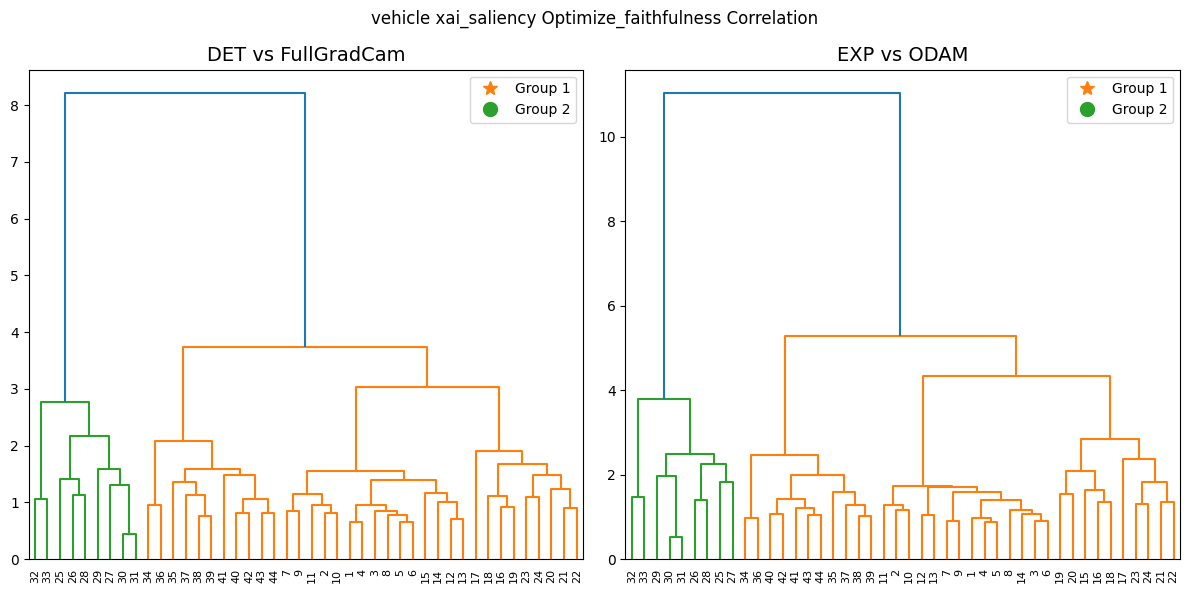

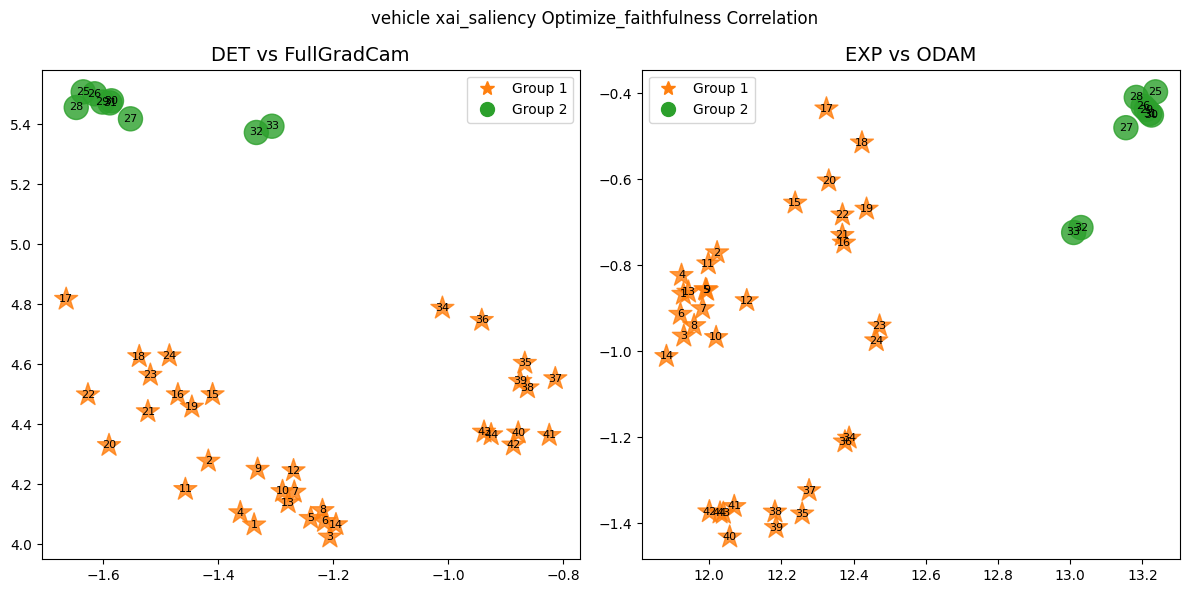

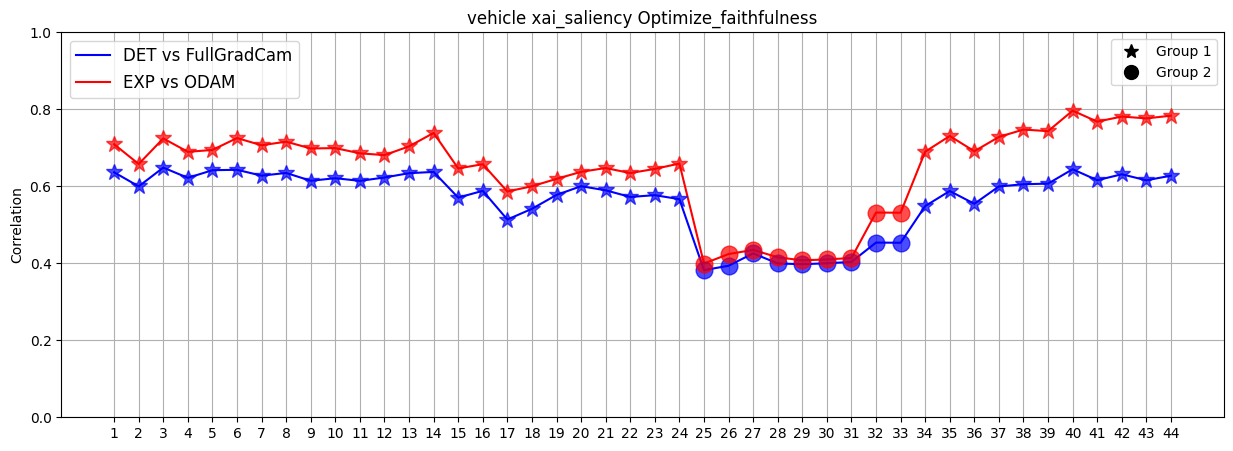

DET vs FullGradCam dropped 12
EXP vs ODAM dropped 12


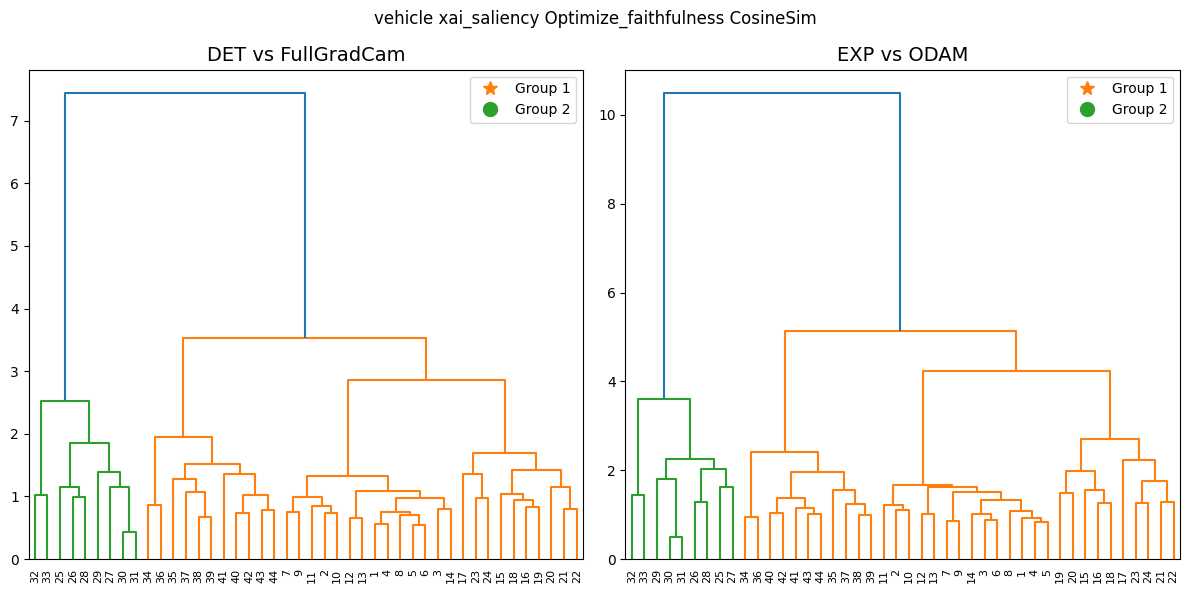

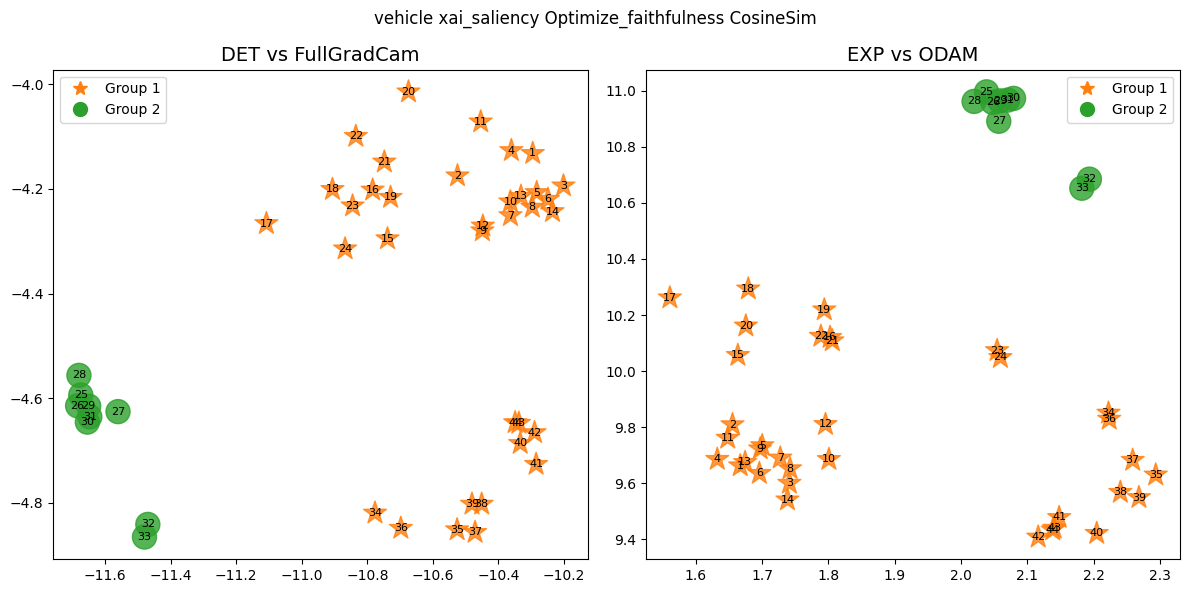

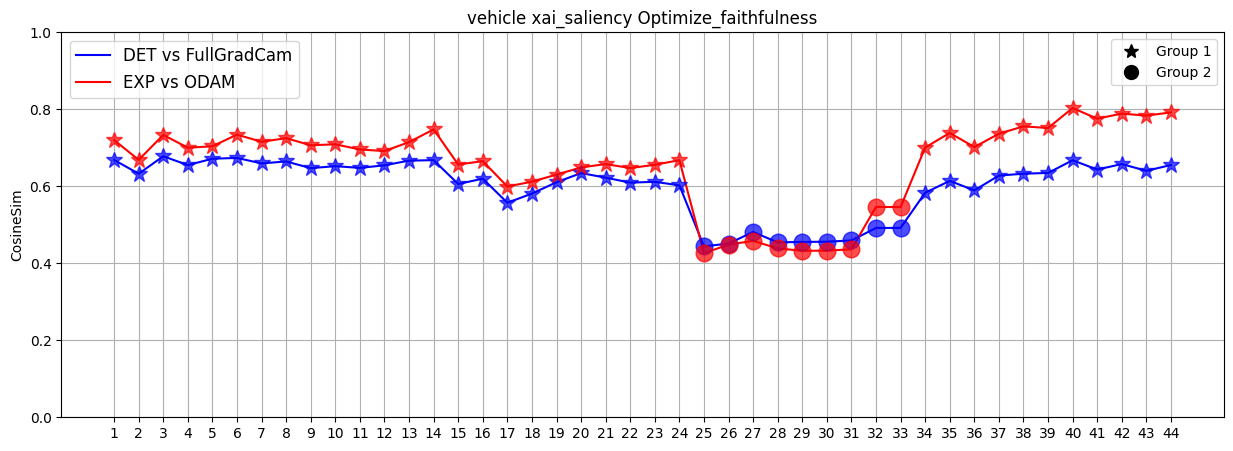

DET vs FullGradCam dropped 12
EXP vs ODAM dropped 12


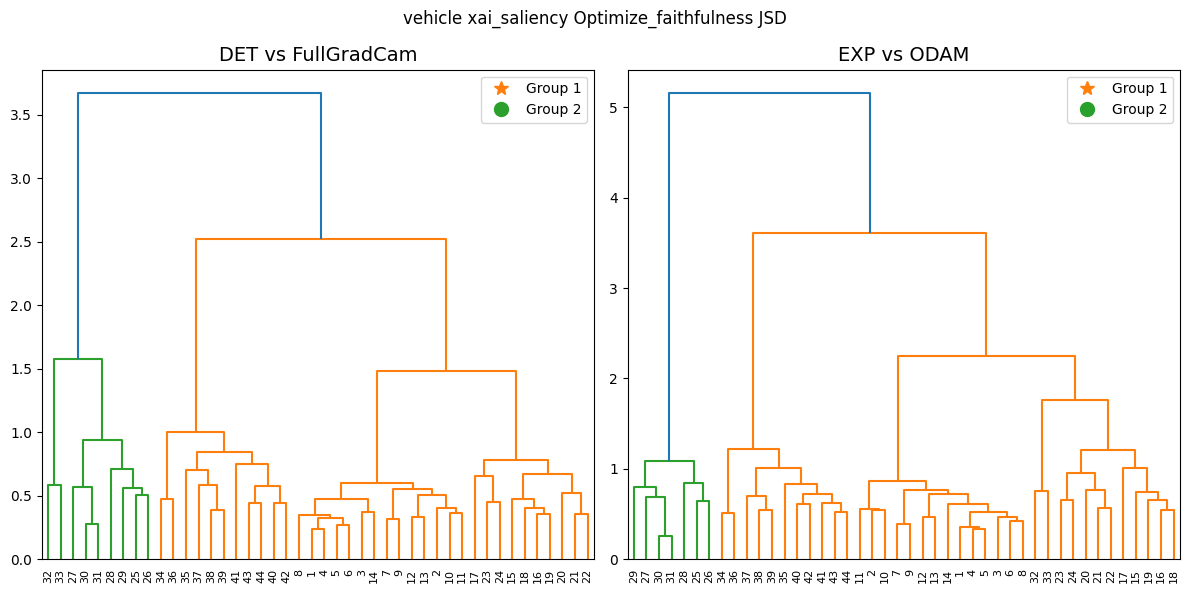

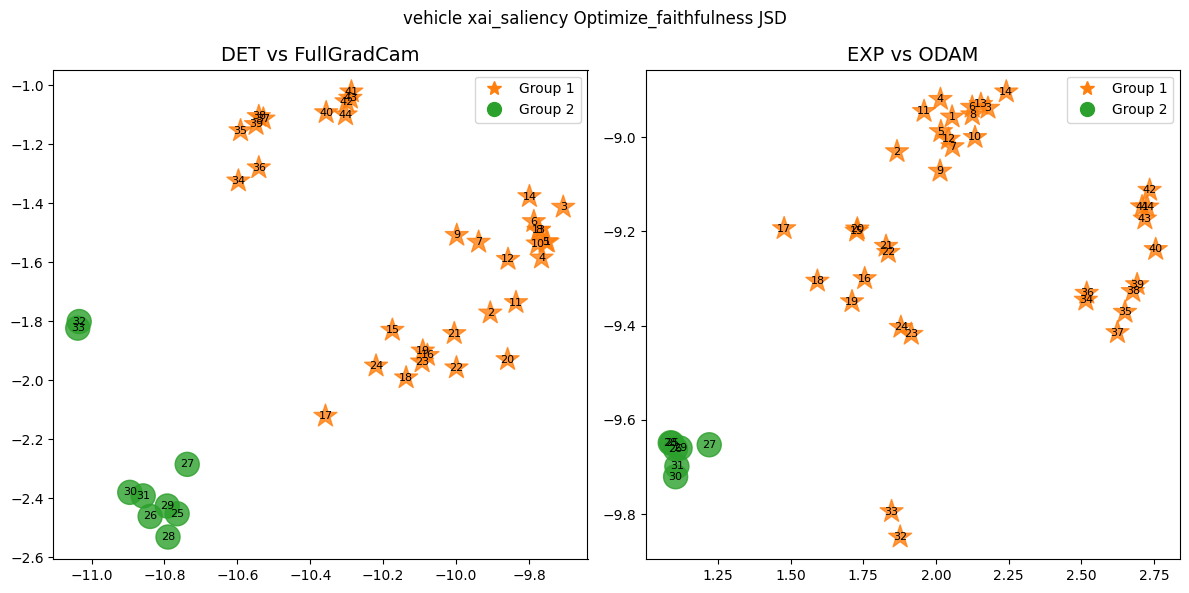

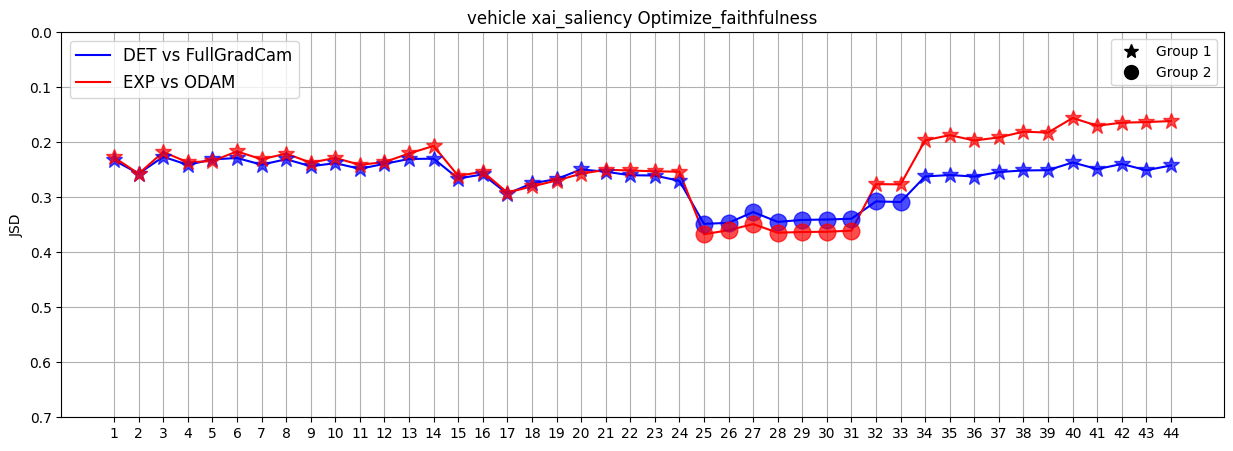

DET vs FullGradCam dropped 12
EXP vs ODAM dropped 12


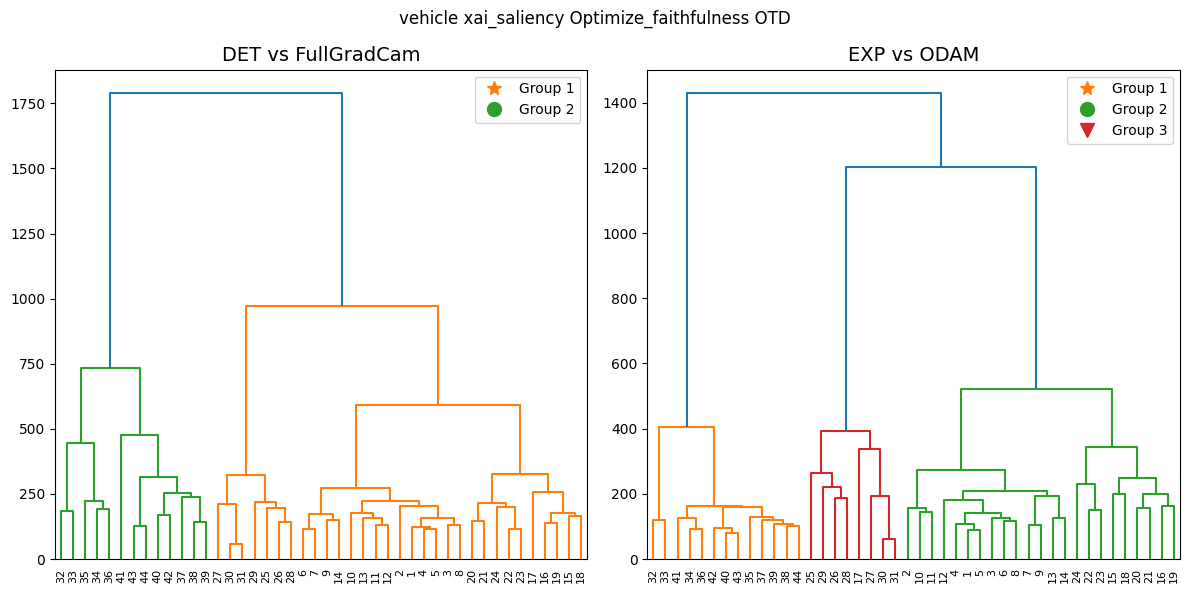

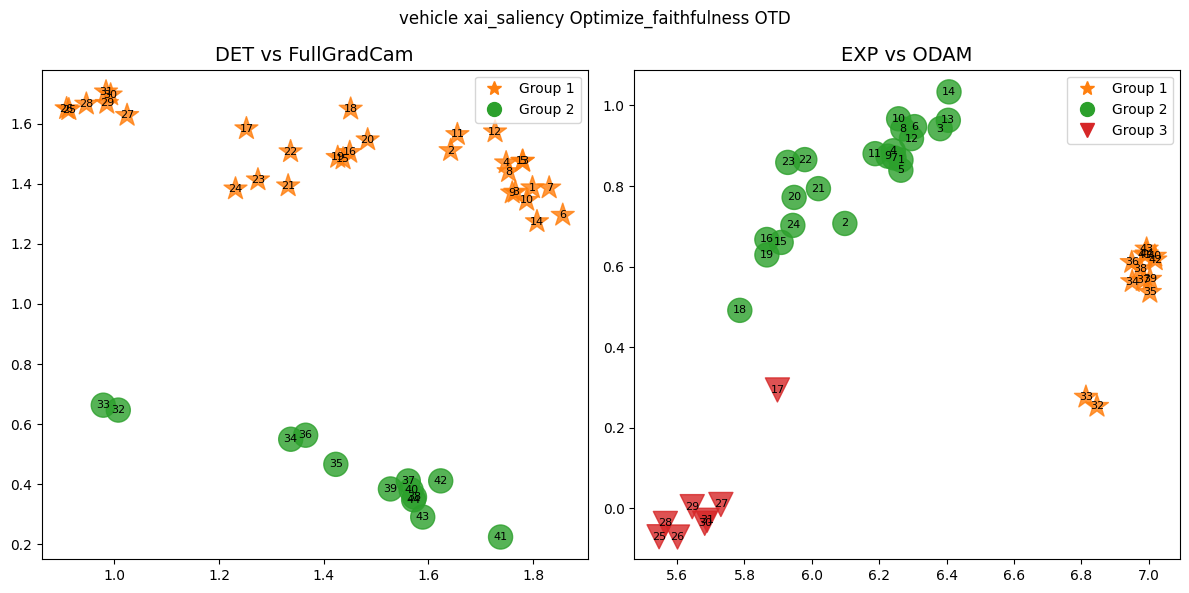

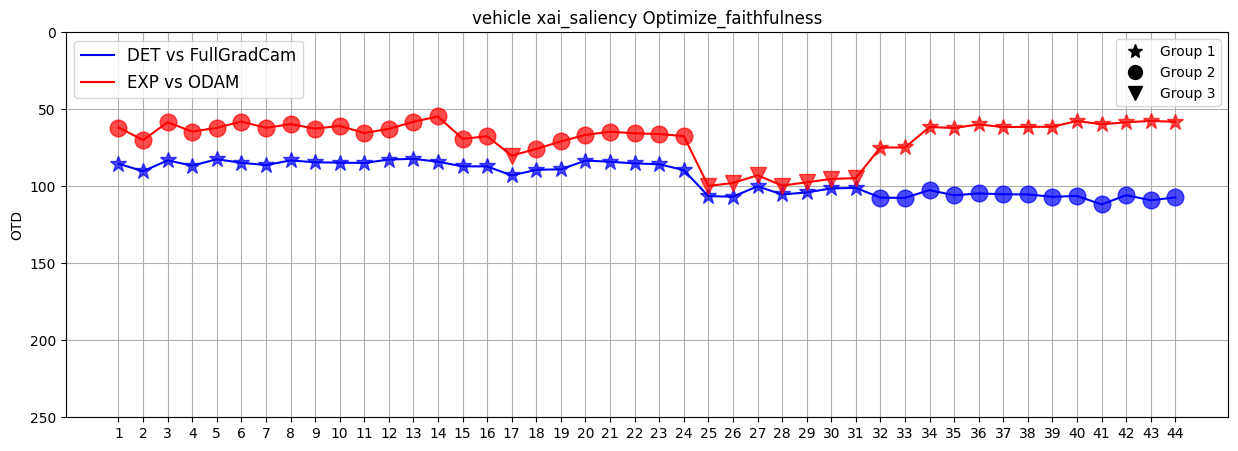

DET vs FullGradCam dropped 16
EXP vs ODAM dropped 16


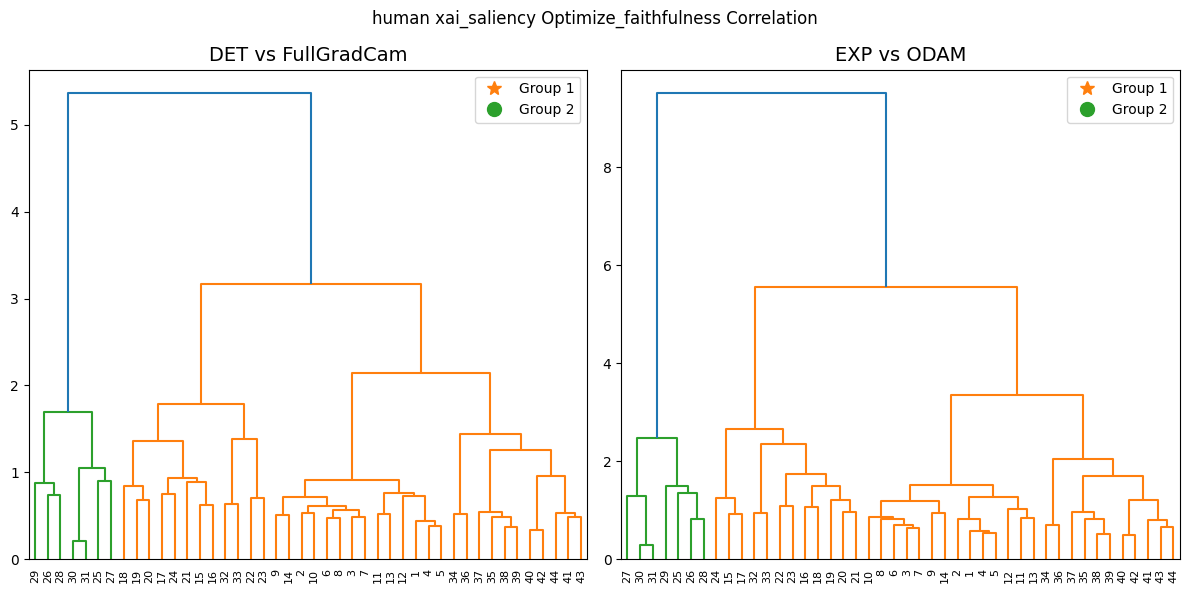

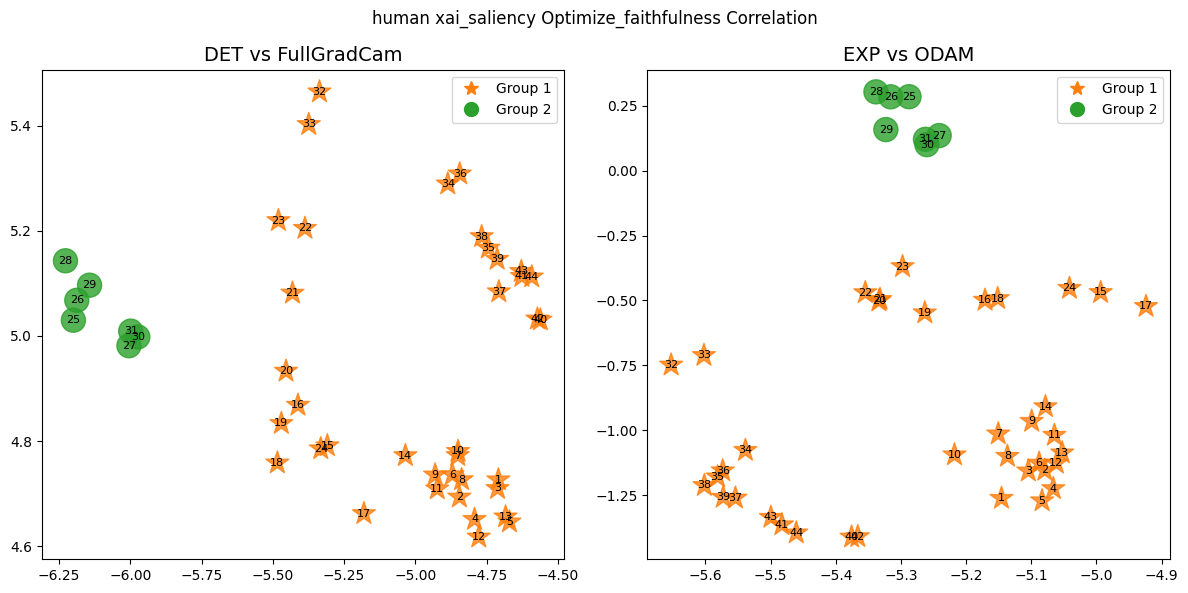

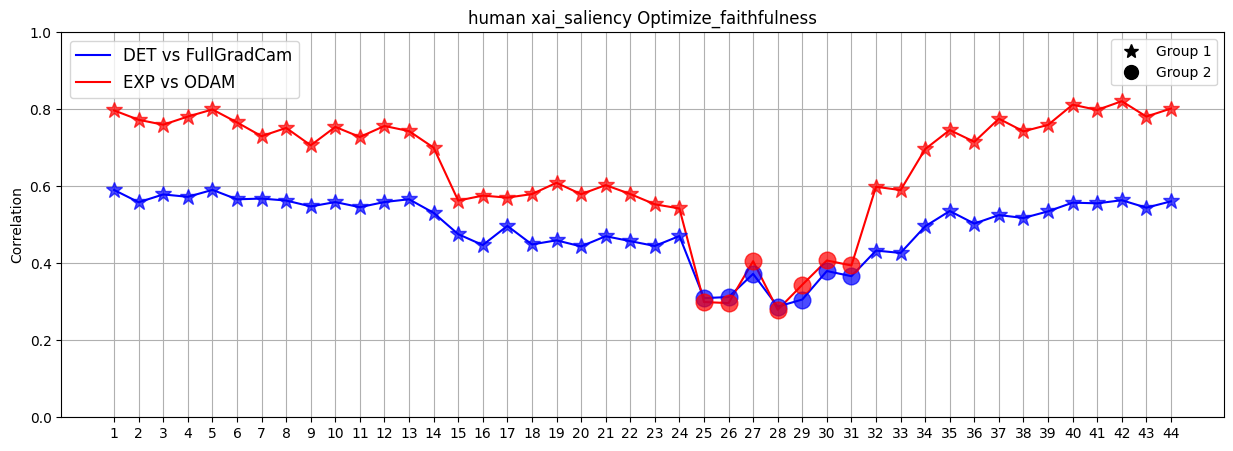

DET vs FullGradCam dropped 16
EXP vs ODAM dropped 16


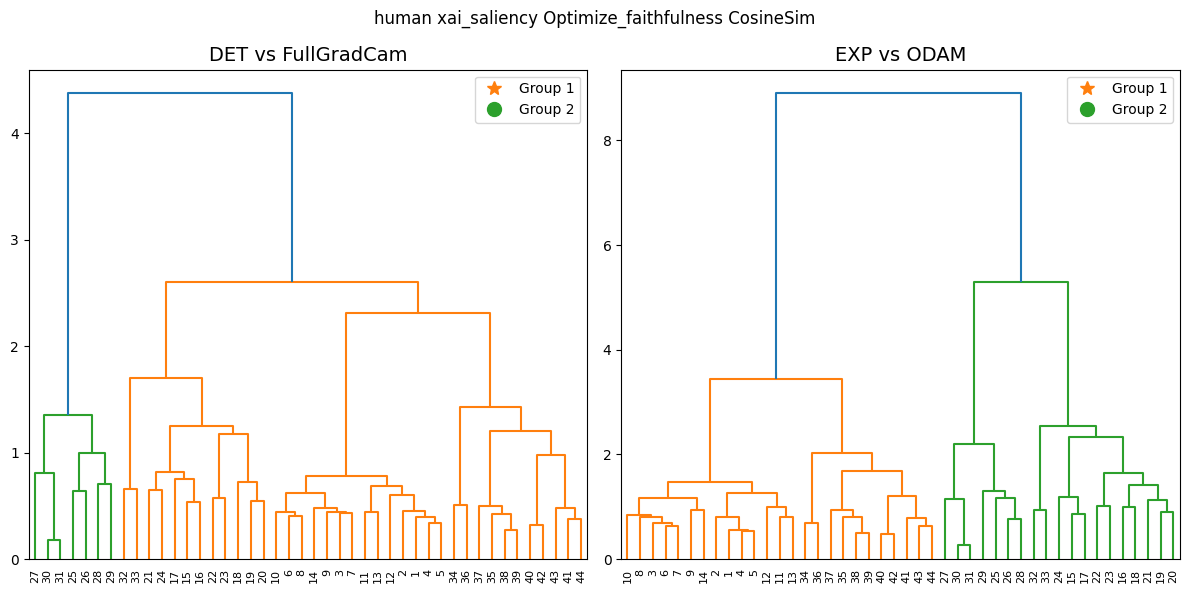

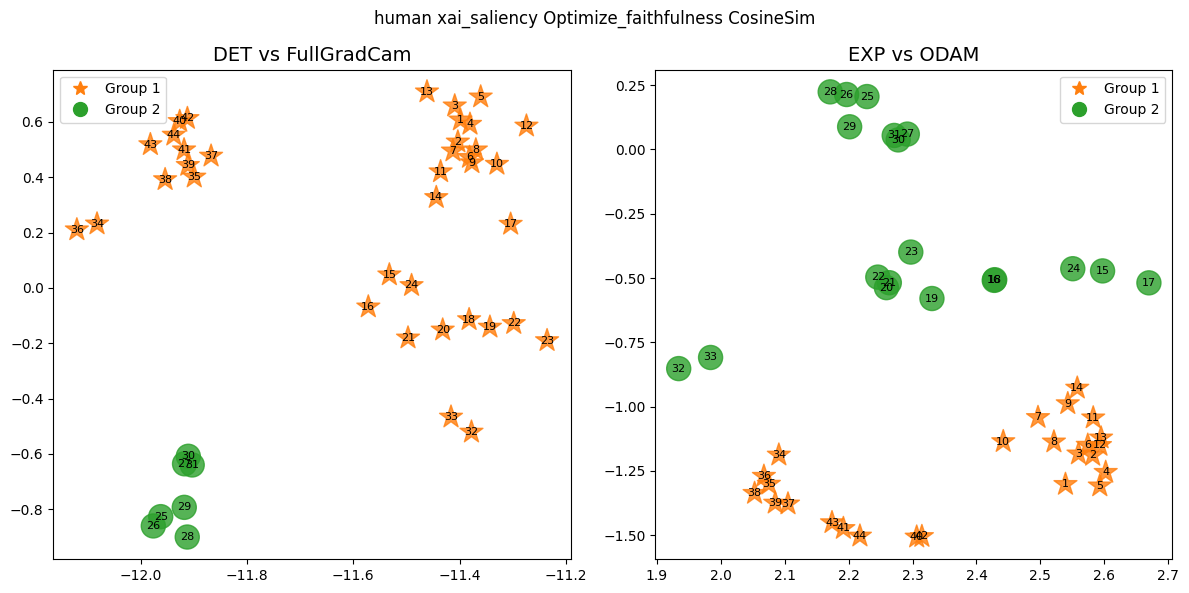

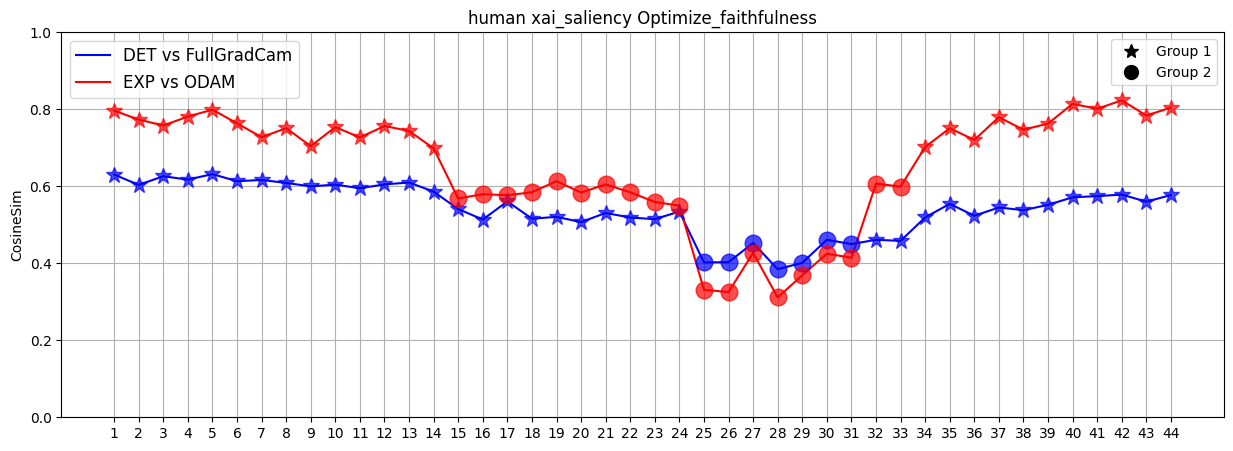

DET vs FullGradCam dropped 16
EXP vs ODAM dropped 16


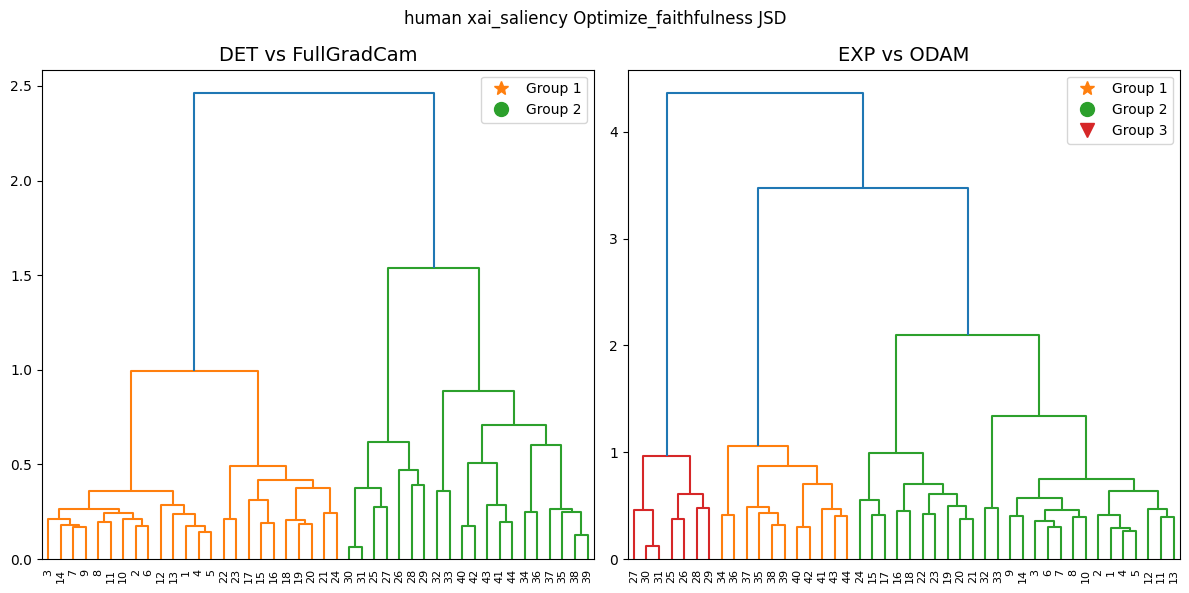

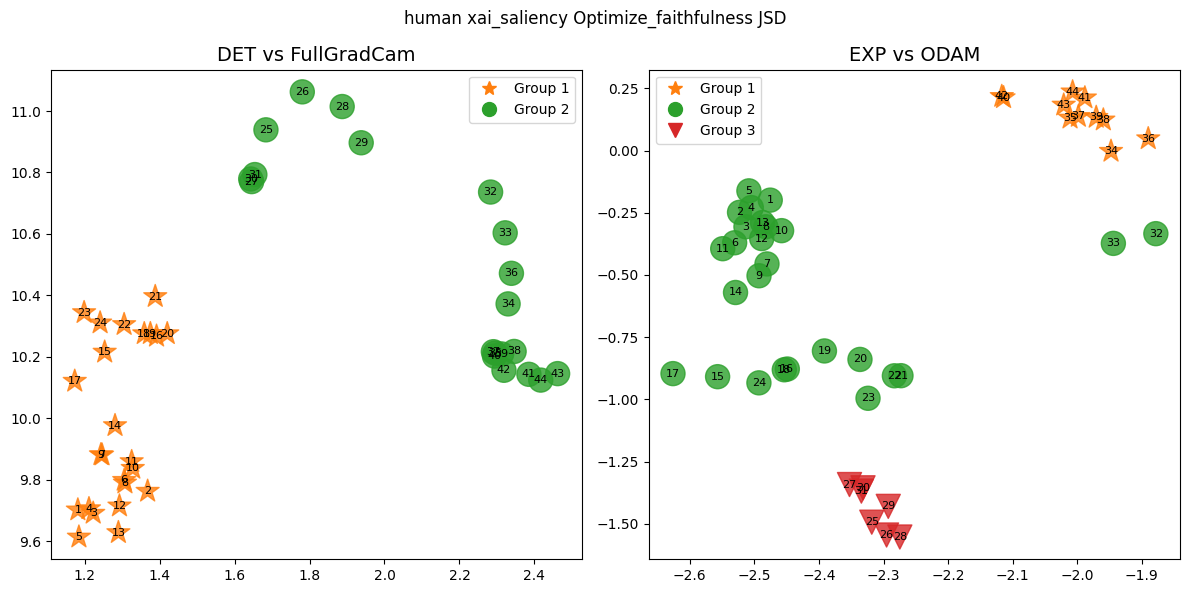

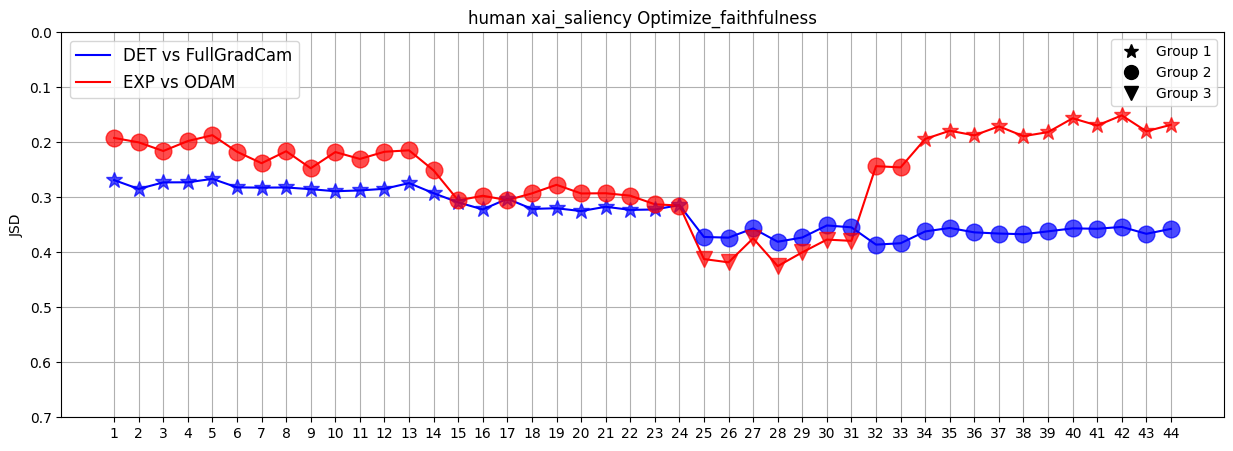

DET vs FullGradCam dropped 16
EXP vs ODAM dropped 16


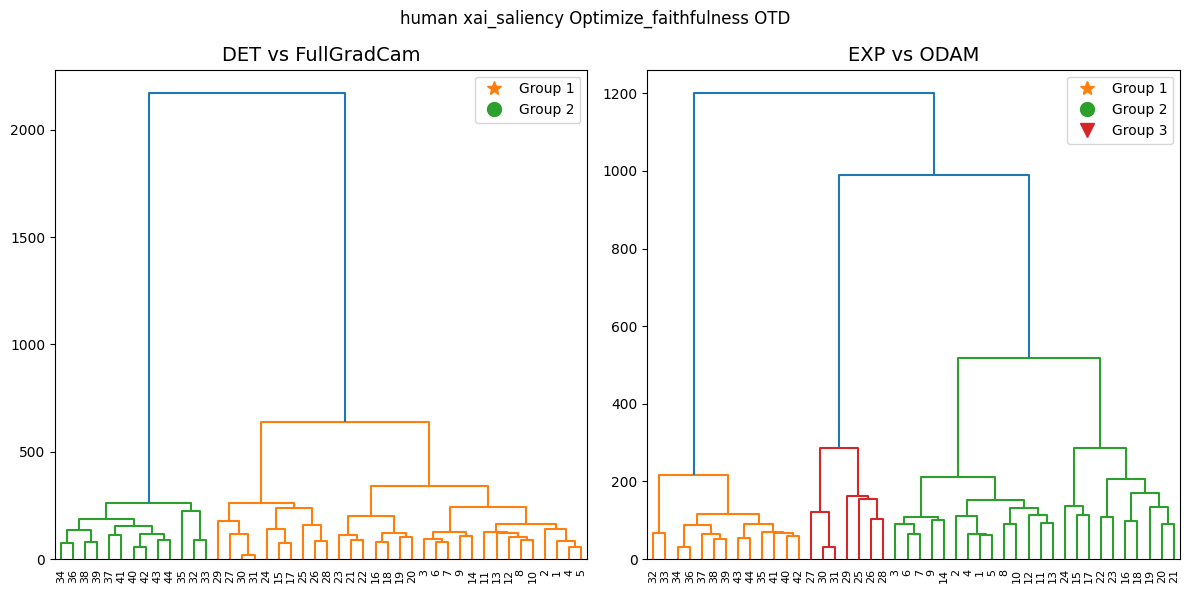

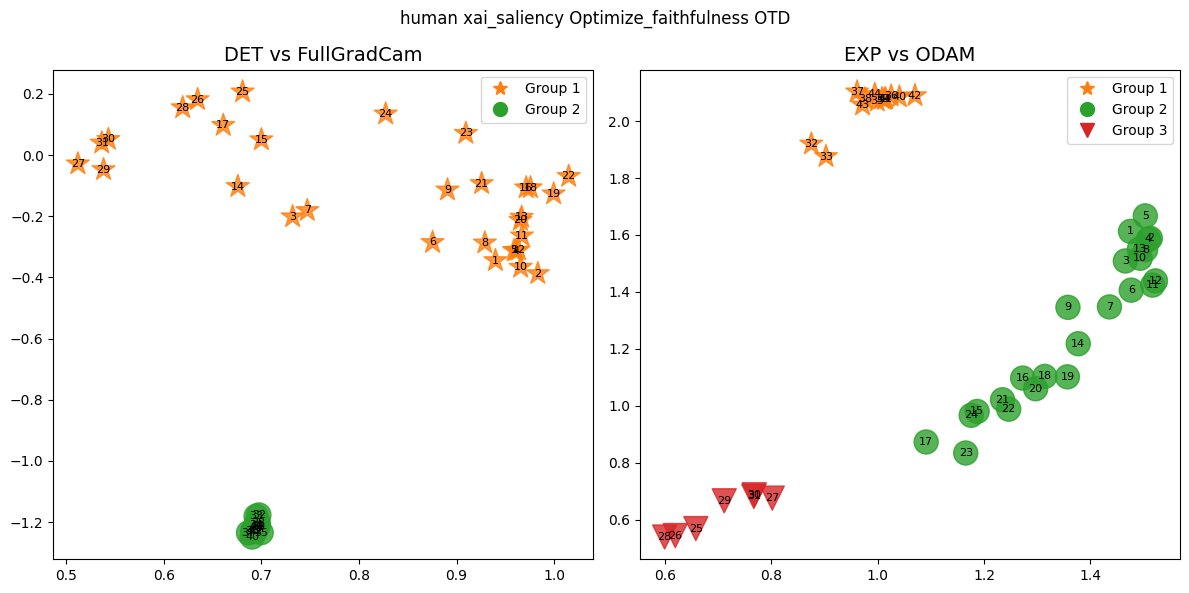

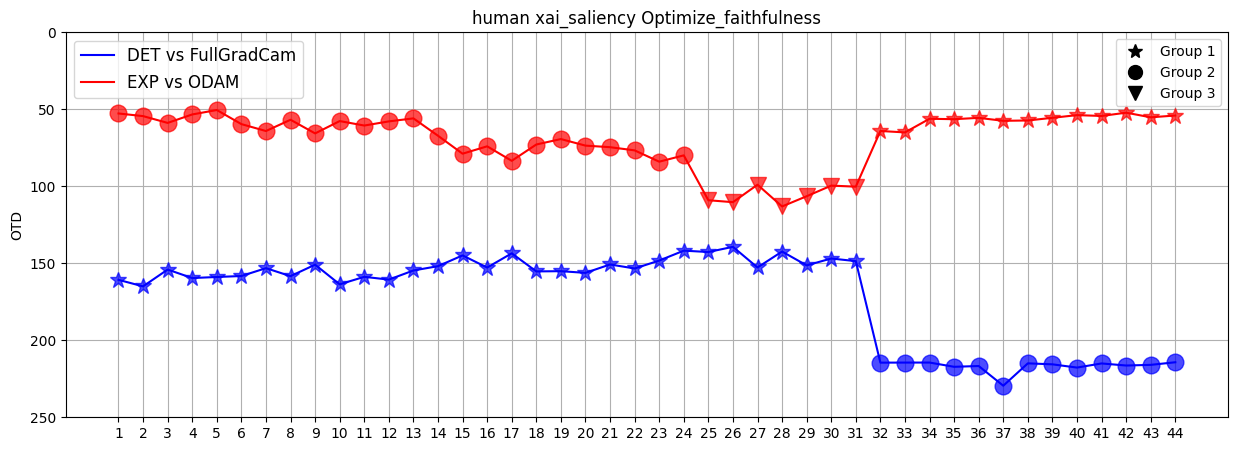

In [12]:
for object in ['vehicle','human']:

    for rescale_method in ['Optimize_faithfulness']:

        for is_act in ['xai_saliency']:

            layer_name_mapping = ['model_1_act', 'model_2_cv1_act', 'model_2_cv2_act', 'model_2_m_0_cv1_act', 'model_2_m_0_cv2_act', 'model_2_cv3_act', 'model_3_act', 'model_4_cv1_act', 'model_4_cv2_act', 'model_4_m_0_cv1_act', 'model_4_m_0_cv2_act', 'model_4_m_1_cv1_act', 'model_4_m_1_cv2_act', 'model_4_cv3_act', 'model_5_act', 'model_6_cv1_act', 'model_6_cv2_act', 'model_6_m_0_cv1_act', 'model_6_m_0_cv2_act', 'model_6_m_1_cv1_act', 'model_6_m_1_cv2_act', 'model_6_m_2_cv1_act', 'model_6_m_2_cv2_act', 'model_6_cv3_act', 'model_7_act', 'model_8_cv1_act', 'model_8_cv2_act', 'model_8_m_0_cv1_act', 'model_8_m_0_cv2_act', 'model_8_cv3_act', 'model_9_cv1_act', 'model_9_cv2_act', 'model_10_act', 'model_13_cv1_act', 'model_13_cv2_act', 'model_13_m_0_cv1_act', 'model_13_m_0_cv2_act', 'model_13_cv3_act', 'model_14_act', 'model_17_cv1_act', 'model_17_cv2_act', 'model_17_m_0_cv1_act', 'model_17_m_0_cv2_act', 'model_17_cv3_act']

            if rescale_method == 'Optimize_faithfulness':
                rescale_path = 'optimize_faithfulness_finer_v2.5'
            else:
                rescale_path = 'bilinear'

            root_dir = f'/home/jinhanz/cs/xai/results/bdd/250115_{rescale_path}_{is_act}_maps_yolov5s'

            for measure, higherMoreSimilar in measures.items():

                similarity_all = pickle.load(open(f'{root_dir}/{object}_{measure}_all_conv.pickle','rb'))

                similarity_layer_mean = defaultdict()

                for analysis in similarity_all.keys():
                    similarity_layer_mean[analysis] = pd.DataFrame.from_dict(similarity_all[analysis]).mean(axis=0)

                dfs = {}
                similarity_mean = {}
                dropped_dfs = {}

                # reverse layer numbering
                for analysis in focused_analysis:
                    df = pd.DataFrame.from_dict(similarity_all[analysis])

                    dfs[analysis] = df.T
                    similarity_mean[analysis] = df.T.mean(axis=1)

                    # dfs[analysis].to_csv(f'{root_dir}/mscoco_{is_act}_{rescale_method}_PCC_all_conv.csv',index=False)

                membership = defaultdict()
                group_rank = defaultdict()
                layer_to_rank = defaultdict(defaultdict) # name : rank

                """
                Dendrogram
                """
                fig, axs = plt.subplots(nrows=1, ncols=2,figsize=[12,6])
                for a, analysis in enumerate(focused_analysis):
                    idx = 0
                    params = param_grid[0]
                    res, clusters, dropped_dfs[analysis] = fit_model(dfs,axs[a],analysis,params[0],params[1],higherMoreSimilar)
                    membership[analysis] = clusters
                    
                    # legends
                    group_mean = {}
                    for g, group in membership[analysis].items():
                        inds = [idx-1 for idx in group]
                        layers = [layer_name_mapping[idx] for idx in inds]
                        mean = similarity_mean[analysis][layers].mean()
                        group_mean[g] = mean
                        # print(f"{g} {mean} {sorted(group)}")

                    # Sort by cluster mean similarity to human attention
                    group_rank[analysis] = {k: rank for rank, (k, v) in enumerate(sorted(group_mean.items(), key=lambda item: item[1], reverse=higherMoreSimilar))}

                    for g, group in membership[analysis].items():
                        for l in group:
                            layer_to_rank[analysis][layer_name_mapping[l-1]] = group_rank[analysis][g]

                    group_markers = []
                    default_colors = ['C1','C2','C3','C4','C5','C6','C7','C8','C9']
                    for g, ord in dict(sorted(group_rank[analysis].items(), key=lambda item: item[1])).items():
                        group_marker = mlines.Line2D([], [], color=default_colors[ord], marker=cluster_labels[group_rank[analysis][g]], linestyle='None',
                                                markersize=10, label=f'Group {group_rank[analysis][g]+1}')
                        group_markers.append(group_marker)

                    axs[a].legend(handles=group_markers,loc='upper right')

                    # print(clusters)
                    if res != None: idx += 1
                    axs[a].set_title(analysis,fontsize=14)
                fig.suptitle(f"{object} {is_act} {rescale_method} {measure}")
                plt.tight_layout()
                plt.draw()

                """
                Table
                """
                #DEBUG
                # print(f"{is_act} {rescale_method} {measure}")
                layer_to_rank_df = pd.DataFrame.from_dict(layer_to_rank) + 1
                layer_to_rank_df = layer_to_rank_df.reindex(layer_name_mapping)
                layer_to_rank_df.to_csv(os.path.join('./membership/',f"{object}_{is_act}_{rescale_method}_{measure}.csv"), index=False)

                """
                t-SNE
                """
                fig, axs = plt.subplots(nrows=1, ncols=2,figsize=[12,6])
                for a, analysis in enumerate(focused_analysis):
                    if 'rpn' in is_act:
                        tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
                    else:
                        tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, random_state=42)
                    X = dropped_dfs[analysis].to_numpy()
                    cluster_tsne = [layer_to_rank[analysis][layer] for layer in dropped_dfs[analysis].index]
                    color_tsne = [default_colors[layer_to_rank[analysis][layer]] for layer in dropped_dfs[analysis].index]
                    X_tsne = tsne.fit_transform(X)

                    # Initialize scatter plot
                    for cluster_idx in set(cluster_tsne):  # Iterate through unique clusters
                        cluster_mask = [y == cluster_idx for y in cluster_tsne]
                        cluster_points = X_tsne[cluster_mask]
                        cluster_layers = (np.arange(len(cluster_tsne)) + 1)[cluster_mask]
                        
                        axs[a].scatter(
                            cluster_points[:, 0],
                            cluster_points[:, 1],
                            c=[default_colors[cluster_idx] for _ in range(len(cluster_points))],
                            marker=cluster_labels[cluster_idx],
                            label=f"Cluster {cluster_idx+1}",
                            s=300,
                            alpha=0.8
                        )
                        
                        # Add annotations for each point
                        for i, (x, y) in enumerate(cluster_points):
                            axs[a].text(
                                x, y, f"{cluster_layers[i]}", fontsize=8, ha="center", va="center"
                            )
                
                    # Legend
                    group_markers = []
                    for g, ord in dict(sorted(group_rank[analysis].items(), key=lambda item: item[1])).items():
                        group_marker = mlines.Line2D([], [], color=default_colors[ord], marker=cluster_labels[group_rank[analysis][g]], linestyle='None',
                                                markersize=10, label=f'Group {group_rank[analysis][g]+1}')
                        group_markers.append(group_marker)

                    axs[a].legend(handles=group_markers)
                    axs[a].set_title(analysis,fontsize=14)
                fig.suptitle(f"{object} {is_act} {rescale_method} {measure}")
                plt.tight_layout()
                plt.draw()


                # Overall similarity
                plt.figure(figsize=(15, 5))
                plt.grid()
                ax = plt.gca()
                # plt.xlabel('Layer')
                plt.ylabel(measure)
                if measure == 'Correlation' or measure == 'CosineSim':
                    if 'saliency' in is_act:
                        ylims = [0,1]
                    else:
                        ylims = [-0.5,0.7]
                elif measure == 'JSD':
                    if 'saliency' in is_act:
                        ylims = [0.7,0]
                    else:
                        ylims = [0.7,0]
                elif measure == 'OTD':
                    ylims = [250,0]
                elif measure == 'RMSE':
                    if 'saliency' in is_act:
                        ylims = [0.3,0]
                    else:
                        ylims = [0.3,0]

                for analysis in focused_analysis:
                    label = analysis if 'saliency' in is_act else analysis.replace('FullGradCam','Activation (Whole-Image)').replace('ODAM','Activation (Instance)')
                    plt.plot(np.arange(len(similarity_mean[analysis]))+1, list(similarity_mean[analysis]),label=label,c=color_code[analysis])
                    plt.xticks(np.arange(len(similarity_mean[analysis]))+1, [f"{l+1}" for l,layer in enumerate(layer_name_mapping)]) #rotation=-90
                    plt.ylim(ylims)

                # Highlight specific layers
                for tick, label in zip(ax.get_xticks(), ax.get_xticklabels()):
                    if layer_name_mapping[tick-1] in cogsci_layer:
                        label.set_fontweight('bold')

                    if layer_name_mapping[tick-1] in special_layer_start:
                        label.set_color('red')

                if 'saliency' in is_act:
                    legend1 = plt.legend(fontsize=12, loc='upper left')
                else:
                    legend1 = plt.legend(fontsize=12, loc='lower left')
                ax.add_artist(legend1)

                all_long_df = pd.DataFrame()
                all_wide_df = pd.DataFrame()

                for analysis in focused_analysis:
                    # print(analysis)
                    group_mean = {}
                    for g, group in membership[analysis].items():
                        inds = [idx-1 for idx in group]
                        layers = [layer_name_mapping[idx] for idx in inds]
                        mean = similarity_mean[analysis][layers].mean()
                        group_mean[g] = mean
                        # print(f"{g} {mean} {sorted(group)}")

                    # Sort by cluster mean similarity to human attention
                    group_rank = {k: rank for rank, (k, v) in enumerate(sorted(group_mean.items(), key=lambda item: item[1], reverse=higherMoreSimilar))}
                    # print(group_rank)

                    # print(labels[analysis])
                    for g, group in membership[analysis].items():
                        marker = cluster_labels[group_rank[g]]
                        for l in group:
                            layer_name = layer_name_mapping[l-1]
                            plt.plot(l,similarity_mean[analysis][layer_name],marker=marker,c=color_code[analysis],markersize=12,alpha=0.7)

                    # Significance analysis

                    if "activation" in is_act: continue

                    data = dropped_dfs[analysis]
                    groups = membership[analysis]

                    layer_to_group = {}
                    for group, layers in groups.items():
                        for l in layers:
                            layer_to_group[layer_name_mapping[l-1]] = group_rank[group] + 1

                    df = data.copy()
                    df.reset_index(inplace=True)  # Reset index
                    df.rename(columns={'index': 'Layer'}, inplace=True)
                    df['Cluster'] = df['Layer'].map(layer_to_group)
                    df['Task'] = analysis

                    long_df = pd.melt(
                                    df,
                                    id_vars=['Layer', 'Cluster','Task'],    # Columns to keep
                                    var_name='Image',                # New column for feature names
                                    value_name='Similarity'              # New column for feature values
                                )

                    all_long_df = pd.concat([all_long_df, long_df], ignore_index=True)
                    all_wide_df = pd.concat([all_wide_df, df], ignore_index=True)

                if "activation" not in is_act: 

                    all_long_df.to_csv(os.path.join('./stats_long/',f"{object}_{is_act}_{rescale_method}_{measure}.csv"))
                    all_wide_df.to_csv(os.path.join('./stats_wide/',f"{object}_{is_act}_{rescale_method}_{measure}.csv"))

                # plt.plot(PCC_mean[analysis].index[12:18].values, PCC_mean[analysis].values[12:18], marker='o',fillstyle='none',label=analysis,c=color_code[analysis],alpha=alpha)

                group_markers = []
                group1_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[0], linestyle='None',
                                        markersize=10, label='Group 1')
                group_markers.append(group1_marker)
                group2_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[1], linestyle='None',
                                        markersize=10, label='Group 2')
                group_markers.append(group2_marker)

                if len([m for _, m in membership.items() if len(m)>=3])>0:
                    group3_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[2], linestyle='None',
                                            markersize=10, label='Group 3')
                    group_markers.append(group3_marker)

                if len([m for _, m in membership.items() if len(m)>=4])>0:
                    group4_marker = mlines.Line2D([], [], color='black', marker=cluster_labels[3], linestyle='None',
                                            markersize=10, label='Group 4')
                    group_markers.append(group4_marker)

                if 'saliency' in is_act:
                    legend2=plt.legend(handles=group_markers,loc='upper right')
                else:
                    legend2=plt.legend(handles=group_markers,loc='lower right')

                plt.title(f"{object} {is_act} {rescale_method}")
                plt.show()
